# MNIST using PyTorch

## Python package imports

In [25]:
%matplotlib inline
from time import time

import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from torch import no_grad, exp
from torch.nn import Sequential, Linear, ReLU, LogSoftmax, NLLLoss
from torch.optim import SGD
from torch.utils.data import DataLoader

## Project settings

In [26]:
DATABASE_DIR = "./datasets/"
BATCH_SIZE = 64
LEARNING_RATE = 0.003
MOMENTUM = 0.9
EPOCHS = 15

## Image transform definition

In [27]:
transform = Compose(
    [
        ToTensor(),
        Normalize((0.5,), (0.5,)),
    ]
)

## Download the MNIST datasets

In [28]:
train_set = MNIST(
    DATABASE_DIR,
    download=True,
    train=True,
    transform=transform,
)

validation_set = MNIST(
    DATABASE_DIR,
    download=True,
    train=False,
    transform=transform,
)

## Create data loaders

In [29]:
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

validation_loader = DataLoader(
    validation_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

## Quick dataset EDA

In [30]:
# Check the size of images / labels
data_iterator = iter(train_loader)
images, labels = data_iterator.next()
print(f"Images shape: {images.shape}.")
print(f"Labels shape: {labels.shape}.")

Images shape: torch.Size([64, 1, 28, 28]).
Labels shape: torch.Size([64]).


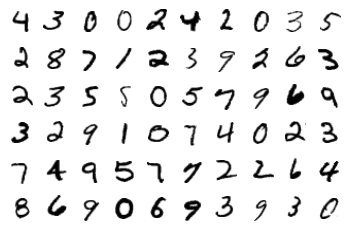

In [31]:
# Print 60 images to preview
figure = plt.figure()
n_images = 60
for index in range(1, n_images + 1):
    plt.subplot(6, 10, index)
    plt.axis("off")
    plt.imshow(images[index].numpy().squeeze(), cmap="gray_r")

## Create the model

The model consists of:

- Input layer (784),
- 2 Hidden Layers with ReLU (128, 64),
- Output layer (10).


In [32]:
def create_model(input_size=784, hidden_sizes=(128, 64), output_size=10):
    return Sequential(
        Linear(input_size, hidden_sizes[0]),
        ReLU(),
        Linear(hidden_sizes[0], hidden_sizes[1]),
        ReLU(),
        Linear(hidden_sizes[1], output_size),
        LogSoftmax(dim=1),
    )


model = create_model()

## Calculate the NLL loss

In [33]:
criterion = NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logps = model(images)
loss = criterion(logps, labels)

loss.backward()

## Define the optimizer (SGD)

In [34]:
optimizer = SGD(
    model.parameters(),
    lr=LEARNING_RATE,
    momentum=MOMENTUM,
)

## Train the model

In [35]:
start_time = time()
for epoch in range(EPOCHS):
    running_loss = 0
    for images, labels in train_loader:
        # Flatten MNIST images into 784 (28x28) vector
        images = images.view(images.shape[0], -1)

        # Training pass
        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)

        # Backpropagation
        loss.backward()

        # Optimizing weights
        optimizer.step()

        running_loss += loss.item()
    else:
        print(f"Epoch {epoch} - Training loss: {running_loss / len(train_loader)}")

print(f"Training time (in minutes) = {(time() - start_time) / 60}")

Epoch 0 - Training loss: 0.6422516217491011
Epoch 1 - Training loss: 0.2792835832674747
Epoch 2 - Training loss: 0.21583654956300374
Epoch 3 - Training loss: 0.1754414754441139
Epoch 4 - Training loss: 0.14882373833445026
Epoch 5 - Training loss: 0.12869941682092098
Epoch 6 - Training loss: 0.11071899929629968
Epoch 7 - Training loss: 0.09892170674610398
Epoch 8 - Training loss: 0.09066758764240501
Epoch 9 - Training loss: 0.08210489956705745
Epoch 10 - Training loss: 0.07451290078858323
Epoch 11 - Training loss: 0.06860052111066148
Epoch 12 - Training loss: 0.06207847015173641
Epoch 13 - Training loss: 0.057842991541949974
Epoch 14 - Training loss: 0.053955469234560585
Training time (in minutes) = 1.9775281151135762


## Testing and evaluation

In [36]:
correct_count = 0
all_count = 0

for images, labels in validation_loader:
    for index in range(len(labels)):
        img = images[index].view(1, 784)
        with no_grad():
            logps = model(img)

        ps = exp(logps)
        probability = list(ps.numpy()[0])
        predicted_label = probability.index(max(probability))
        true_label = labels.numpy()[index]

        if predicted_label == true_label:
            correct_count += 1
        all_count += 1

print(f"Number of images = {all_count}")
print(f"Model accuracy = {correct_count / all_count}")

Number of images = 10000
Model accuracy = 0.9752
